In [2]:
import pandas as pd
import os

assets_dir = os.path.join('assets', 'data')

def _load_csv(path):
    return pd.read_csv(path, low_memory=False)

In [16]:
files = ['dws_wages.csv', 'usbe_students.csv', 'ushe_students.csv', 'ustc_students.csv']

dataframes = {}

for file in files:
    dataframes[file] = _load_csv(os.path.join(assets_dir, file))

## Count IDs

Get count of all IDs in files list

In [18]:
ids = []
for file in dataframes:
    ids.extend(dataframes[file].id.tolist())
    
len(ids), len(set(ids))

(40000, 36135)

## Calculate 'Distance' Between Tables

Assigning existance of columns to a binary vector for each table, a 'distance' between tables can be calculated.

In [65]:
from assets.mapping import colmap, local_identifiers
 

def _get_columns(dataframes: dict) -> dict:
    columns = {}
    for file in dataframes:
        columns[file] = _map_columns(dataframes[file].columns.tolist(), file.split('_')[0])
    return columns


def _map_columns(clist: list, partner: str) -> list:
    def _make_local(c:str, partner:str)->str:
        if c in local_identifiers:
            return partner + '_' + c
        return c
    fc = []
    for col in clist:
        if col in colmap.keys():
            fc.append(_make_local(colmap[col], partner))
    return fc


def _define_max_vector(columns: dict) -> list:
    cset = set()
    for file in columns:
        for colname in columns[file]:
            cset.add(colname)
    return cset


def _convert_collist_to_vector(clist: list, maxv: set) -> dict:
    v = {}
    for c in maxv:
        v[c] = int(c in clist)
    return v

def make_col_frame(dataframes: dict) -> dict:
    vectors = {}
    columns = _get_columns(dataframes)
    max_v = _define_max_vector(columns)
    for file in dataframes:
        vectors[file] = _convert_collist_to_vector(columns[file], max_v)
    
    findex = {}
    [findex.update({file:i}) for i, file in enumerate(columns.keys())]
    
    return pd.DataFrame.from_dict(vectors, orient='index'), findex
    

In [66]:
dframe, findex = make_col_frame(dataframes)

In [67]:
dframe

,first_name_pool,usbe_student_id_pool,ushe_student_id_pool,last_name_pool,birth_date_pool,ssid_pool,ustc_student_id_pool,ssn_pool,gender_pool,middle_name_pool
dws_wages.csv,1,0,0,1,0,0,0,1,0,1
usbe_students.csv,1,1,0,1,1,1,0,0,1,1
ushe_students.csv,1,0,1,1,1,1,0,1,1,1
ustc_students.csv,1,0,0,1,1,0,1,1,1,1


In [71]:
dframe.loc['dws_wages.csv'].to_numpy()

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [82]:
import numpy as np

def calc_distance(dframe: pd.DataFrame, index_a: str, index_b: str) -> float:
    v1 = dframe.loc[index_a].to_numpy()
    v2 = dframe.loc[index_b].to_numpy()
    return np.linalg.norm(v2 - v1)


def get_distances_for_order(dframe: pd.DataFrame, runorder:list):
    dist = []
    for i in range(len(runorder) - 1):
        dist.append(
            calc_distance(dframe, runorder[i], runorder[i+1])
        )
    return dist

In [84]:
get_distances_for_order(dframe, files)

[2.23606797749979, 1.7320508075688772, 1.7320508075688772]

### Calculate Distances in Report

In [94]:
import json
with open('test_report.json', 'r') as file:
    rep = json.load(file)
    
for r in rep:
    r['distances'] = get_distances_for_order(dframe, [x+'.csv' for x in r['name'].split('-')])
    r['max_d'] = max(r['distances'])
    r['avg_d'] = sum(r['distances']) / len(r['distances'])

Convert to dataframe for plotting & analysis

In [98]:
def _get_keys(d:dict, keys:list):
    nd = {}
    for k in keys:
        nd[k] = d[k]
    return nd

vals = [_get_keys(r, ['count_documents', 'count_vectors', 'max_d', 'avg_d']) for r in rep]
vals = pd.DataFrame.from_dict(vals)
vals.head()

,count_documents,count_vectors,max_d,avg_d
0,29284,29346,2.236068,1.900057
1,38659,38735,2.236068,1.989373
2,38006,38006,2.000000,1.910684
3,38006,38006,2.000000,1.910684
4,38617,38617,2.000000,1.821367


### Documents vs max, avg distance

<AxesSubplot:xlabel='avg_d'>

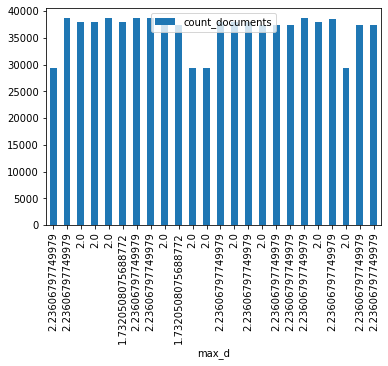

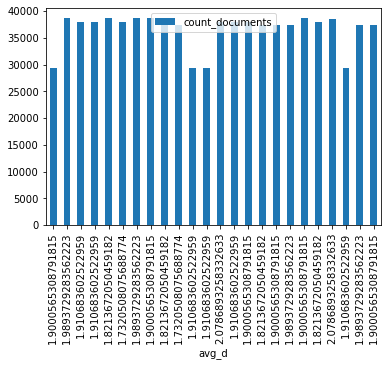

In [105]:
vals.plot('max_d', 'count_documents', 'bar')
vals.plot('avg_d', 'count_documents', 'bar')

### Vectors vs max, avg distance

<AxesSubplot:xlabel='avg_d'>

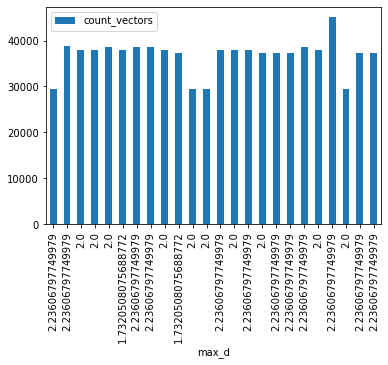

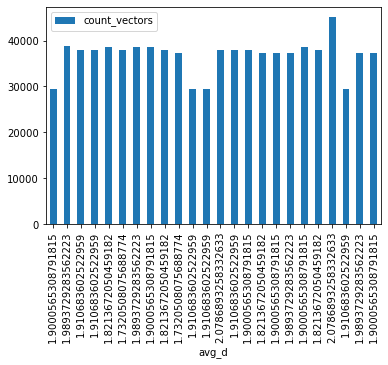

In [106]:
vals.plot('max_d', 'count_vectors', 'bar')
vals.plot('avg_d', 'count_vectors', 'bar')

**Summary** Column vector difference, traversal, is not a good indicator of error.